In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import torch
from tqdm.auto import tqdm
import random
import os


import matplotlib.pyplot as plt
import seaborn as sns


DATA_PATH = '/content/drive/MyDrive/데이콘 캐글 컴페티션/2023신약개발/data/'
SEED = 42


def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [4]:
train.shape, test.shape, submission.shape

((3498, 11), (483, 9), (483, 3))

# 전처리

### -> 이상치 제거 (총 18개)

In [5]:
# 1. 극단치만 판단해서 18개 제거
outliers = train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0) | (train['AlogP'] < -3) | (train['Molecular_Weight'] > 800)
     | (train['Num_H_Acceptors'] > 14) | (train['Num_H_Donors'] > 9) | (train['Num_RotatableBonds'] > 20)
     | (train['LogD'] < -4) | (train['Molecular_PolarSurfaceArea'] > 250)]


In [6]:
outliers.index

Int64Index([ 179,  662,  834,  983, 1092, 1172, 1239, 1584, 2159, 2258, 2367,
            2410, 2586, 2711, 2948, 3157, 3247, 3403],
           dtype='int64')

In [7]:
train = train.drop(index=outliers.index, axis=0)


In [8]:
duplicates = train[train.duplicated(subset=['SMILES'], keep=False)]

duplicates.sort_values(by='SMILES')

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [9]:
processed_duplicate = duplicates.groupby('SMILES')['MLM','HLM'].mean().reset_index()

<ipython-input-9-a090693ccaae>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  processed_duplicate = duplicates.groupby('SMILES')['MLM','HLM'].mean().reset_index()


In [10]:
tmp = pd.merge(processed_duplicate,duplicates,how='left',on='SMILES')

### -> 중복치 제거 (총 26개)

In [11]:
tmp = tmp.iloc[0::2]  # 첫 번째 행부터 시작하여 2씩 증가하여 행 선택
tmp.drop(['MLM_y','HLM_y'],axis =1,inplace=True)

In [12]:
train = train.drop_duplicates(subset=['SMILES'], keep=False) #기존 train에서 중복치들을 우선 모두 제거
train.shape

(3428, 11)

In [13]:
tmp.rename(columns={'HLM_x': 'HLM', 'MLM_x': 'MLM'}, inplace=True)

In [14]:
train = pd.concat([train, tmp], axis=0, ignore_index=True)
train.shape

(3454, 11)

 # MolVec

In [15]:
!conda install openbabel -c openbabel -y


/bin/bash: line 1: conda: command not found


In [16]:
import sys
!conda install --yes --prefix {sys.prefix} -c rdkit rdkit

/bin/bash: line 1: conda: command not found


In [17]:
!pip install git+https://github.com/samoturk/mol2vec


  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-8ykhura9
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-8ykhura9
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14016 sha256=4c39d15fbff826d72dbe491e08299f85fca1b0d977fdf8c4f562b49ce61facb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8buktvtm/wheels/b9/bd/e0/b6dd7c5e346247e8d6944e08ca1c262a908231747f4efa539d
Successfully built mol2vec


In [19]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 13.9 MB/s eta 0:00:00


In [22]:
!pip install pybel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.8/387.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5894 sha256=1d0bddd5dcee7a7c8ae9107e92fe185ddd11ba3d8ce4350c48d3897635b18765
  Stored in directory: /root/.cache/pip/wheels/27/5f/ba/e972a56dcbf5de9f2b7d2b2a710113970bd173c4dcd3d2c902
  Created wheel for pytrie: filename=PyTrie-0.4.0-py3-none-any.whl size=6082 sha256=fab642639cad5272a9ec9f75399504fd9e2fac4e55728ce914f6686cd22dc889
  Stored in directory: /root/.cache/pip/wheels/87/0e/a3/3563272cb57af4afbc50c4c7882dd4540944aadde25c82bd45
Successfully built ratelimit pytrie


In [23]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm

from rdkit import Chem
from mol2vec.features import mol2alt_sentence
import pybel

from gensim.models import Word2Vec

In [25]:
# file_dir = '../input/champs-scalar-coupling/structures/'
mols_files=os.listdir(DATA_PATH)
mols_index=dict(map(reversed,enumerate(mols_files)))
mol_name = list(mols_index.keys())

# train

In [27]:
smiles = train['SMILES'].tolist()

In [30]:
sentence = mol2alt_sentence(Chem.MolFromSmiles(train.SMILES[33]), 1)
print('SMILES:', train.SMILES[33])
print(sentence)

SMILES: Oc1ccc(-c2nc(-c3ccc(F)c(F)c3)no2)cc1Cl
['864662311', '26234434', '3217380708', '3026394695', '3218693969', '951226070', '3218693969', '951226070', '3217380708', '2353112200', '3217380708', '68650007', '2041434490', '1101907775', '3217380708', '4164236649', '3217380708', '2353112200', '3218693969', '951226070', '3218693969', '951226070', '3217380708', '1857396528', '882399112', '3337745083', '3217380708', '1857396528', '882399112', '3337745083', '3218693969', '994485099', '2041434490', '3460898310', '3189457552', '3376021752', '3218693969', '994485099', '3217380708', '2424973678', '1016841875', '3452535345']


In [31]:
# model = Word2Vec.load('../input/mol2vec/model_300dim.pkl')

FileNotFoundError: ignored

# 사전학습 모델

In [36]:
!pip install gensim


In [37]:
import gensim
from gensim.models import Word2Vec


In [32]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00


In [ ]:
model = Word2Vec.load('../input/mol2vec/model_300dim.pkl')

### vocab-transformers/distilbert-word2vec_256k-MLM_1M

In [38]:
from transformers import AutoModel, AutoTokenizer

# 모델 이름 및 토크나이저 이름 지정
model_name = "vocab-transformers/distilbert-word2vec_256k-MLM_1M"
tokenizer_name = "vocab-transformers/distilbert-word2vec_256k-MLM_1M"

# 모델과 토크나이저 불러오기
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# 입력 텍스트
text = "This is an example sentence."

# 텍스트를 토큰화하고 모델에 전달
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# 출력 확인
print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.0121,  0.0457,  0.0071,  ...,  0.0045, -0.0031, -0.0399],
         [-0.1053, -0.0106,  0.0042,  ..., -0.0276,  0.0816,  0.0650],
         [-0.0821, -0.0134, -0.0062,  ...,  0.0364,  0.0544,  0.0853],
         ...,
         [-0.0453, -0.0210, -0.0522,  ..., -0.0185,  0.0117, -0.0640],
         [-0.1759, -0.0071, -0.0400,  ...,  0.0255,  0.0408, -0.0300],
         [-0.0781, -0.0015, -0.0269,  ..., -0.0084,  0.0073,  0.0287]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)


In [39]:
# 입력 텍스트
text = train['SMILES'][0]

# 텍스트를 토큰화하고 모델에 전달
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# 출력 확인
print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.0020,  0.0467,  0.0096,  ...,  0.0359,  0.0188, -0.0183],
         [-0.0047,  0.0696, -0.0419,  ..., -0.0638,  0.1337,  0.0782],
         [-0.0295,  0.0419,  0.0243,  ..., -0.0397,  0.0666,  0.0290],
         ...,
         [-0.1176,  0.0538,  0.0514,  ...,  0.0243,  0.0153,  0.1589],
         [-0.0258,  0.0141,  0.0202,  ..., -0.0162,  0.0748,  0.0447],
         [-0.0403,  0.0203, -0.0054,  ...,  0.0029,  0.0345,  0.0614]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)


In [43]:
# outputs에서 특정 텐서를 추출하여 shape을 확인하거나 다루기
tensor = outputs.last_hidden_state  # 또는 다른 원하는 텐서 선택
tensor_shape = tensor.shape
print(tensor_shape)


torch.Size([1, 30, 768])


In [51]:
tensor.detach().numpy().reshape(-1,1).shape

(23040, 1)

### seyonec/PubChem10M_SMILES_BPE_450k

In [57]:
from transformers import AutoModel, AutoTokenizer

# 모델 이름 및 토크나이저 이름 지정
model_name = "seyonec/PubChem10M_SMILES_BPE_450k"
tokenizer_name = "seyonec/PubChem10M_SMILES_BPE_450k"

# 모델과 토크나이저 불러오기
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)


In [58]:
# 입력 텍스트
text = train['SMILES'][0]

# 텍스트를 토큰화하고 모델에 전달
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# last hidden state 추출
last_hidden_state = outputs.last_hidden_state

# last_hidden_state를 NumPy 배열로 변환
last_hidden_state_np = last_hidden_state.detach().numpy()


In [60]:
last_hidden_state.shape

torch.Size([1, 34, 768])

In [63]:
last_hidden_state_np.shape

(1, 34, 768)

In [66]:
# Torch 텐서를 NumPy 배열로 변환
numpy_array = last_hidden_state.detach().numpy()

# NumPy 배열을 (1, 768) 형태로 펼치기
flattened_numpy_array = numpy_array.reshape(1, -1)  # -1은 다른 차원을 자동으로 조정하도록 지시하는 역할을 합니다.

print(flattened_numpy_array.shape)  # (1, 768)

(1, 26112)


In [76]:
last_hidden_state_pubchem = []

for smiles in train['SMILES']:
    text = train['SMILES'][0]

    # 텍스트를 토큰화하고 모델에 전달
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)

    # last hidden state 추출
    last_hidden_state = outputs.last_hidden_state

    # last_hidden_state를 NumPy 배열로 변환
    numpy_array = last_hidden_state.detach().numpy()
    flattened_numpy_array = numpy_array.reshape(1, -1)  # -1은 다른 차원을 자동으로 조정하도록 지시하는 역할을 합니다.

    print(flattened_numpy_array)  # (1, 768)
    break

#(1, 25344)

[[ 1.136218    0.44850266  1.0037885  ... -0.6621853   1.0623057
   0.5968766 ]]


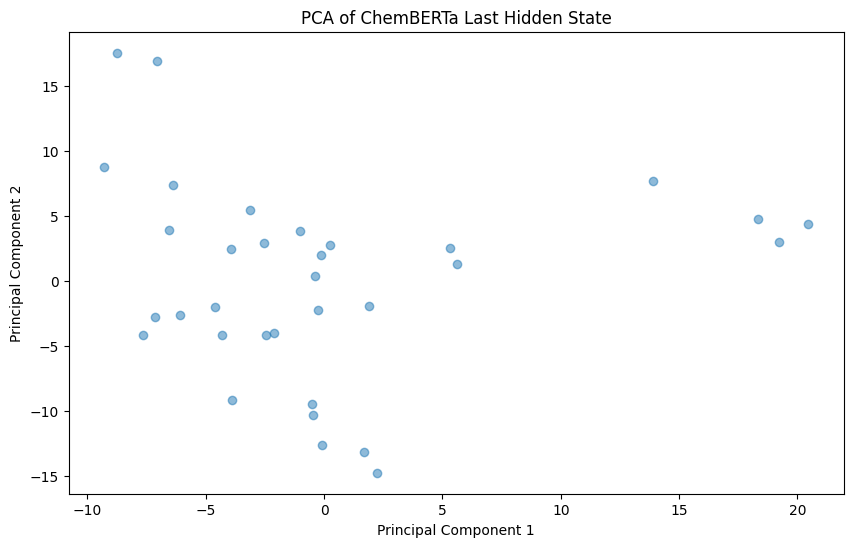

In [78]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# last_hidden_state를 2D PCA 공간으로 축소
pca = PCA(n_components=2)
last_hidden_state_pca = pca.fit_transform(last_hidden_state[0].detach().numpy())

# 산점도를 그리기 위해 데이터를 추출
x = last_hidden_state_pca[:, 0]
y = last_hidden_state_pca[:, 1]

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title("PCA of ChemBERTa Last Hidden State")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [79]:
from sklearn.decomposition import PCA

# 분산 설명 비율을 95%로 설정
pca = PCA(n_components=0.95)

# 주성분 분석을 수행
pca.fit(last_hidden_state[0].detach().numpy())

# 설정한 비율에 맞게 주성분을 선택
reduced_data = pca.transform(last_hidden_state[0].detach().numpy())


In [81]:
reduced_data.shape

(33, 23)

### seyonec/ChemBERTa-zinc-base-v1

In [69]:
from transformers import AutoModel, AutoTokenizer

# 모델 이름 및 토크나이저 이름 지정
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer_name = "seyonec/ChemBERTa-zinc-base-v1"

# 모델과 토크나이저 불러오기
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)


In [71]:
text = train['SMILES'][0]

# 텍스트를 토큰화하고 모델에 전달
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# 'last_hidden_state' 추출
last_hidden_state = outputs.last_hidden_state
print(last_hidden_state)

tensor([[[ 1.1362e+00,  4.4850e-01,  1.0038e+00,  ..., -1.0183e+00,
          -1.5610e+00,  1.2563e+00],
         [ 1.5279e+00, -8.7698e-01, -4.4221e-01,  ...,  7.0027e-01,
           3.3544e-01, -6.2770e-01],
         [-6.4075e-01,  2.3577e+00,  4.8776e-01,  ...,  9.1938e-05,
           8.6798e-01, -3.8317e-01],
         ...,
         [-2.0944e+00,  9.1448e-01,  7.7427e-01,  ..., -1.9615e-02,
           5.9596e-01,  1.8102e-01],
         [-4.6371e-01, -4.5264e-01,  3.1117e-01,  ..., -2.5365e-01,
          -1.0243e+00, -1.4838e+00],
         [ 1.6195e+00,  1.4054e+00,  1.2415e+00,  ..., -6.6219e-01,
           1.0623e+00,  5.9688e-01]]], grad_fn=<NativeLayerNormBackward0>)


In [72]:
last_hidden_state.shape

torch.Size([1, 33, 768])

In [89]:
# Torch 텐서를 NumPy 배열로 변환
numpy_array = last_hidden_state.detach().numpy().sum()

# NumPy 배열을 (1, 768) 형태로 펼치기
flattened_numpy_array = numpy_array.reshape(1, -1)  # -1은 다른 차원을 자동으로 조정하도록 지시하는 역할을 합니다.

print(flattened_numpy_array)  # (1, 768)

[[-2.074174]]


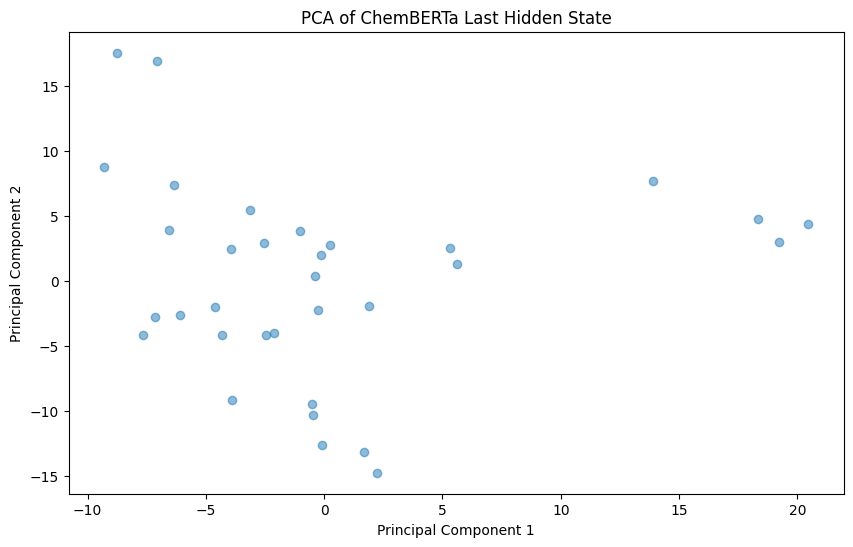

In [85]:
# pyplot as plt
from sklearn.decomposition import PCA

# last_hidden_state를 2D PCA 공간으로 축소
pca = PCA(n_components=2)
last_hidden_state_pca = pca.fit_transform(last_hidden_state[0].detach().numpy())

# 산점도를 그리기 위해 데이터를 추출
x = last_hidden_state_pca[:, 0]
y = last_hidden_state_pca[:, 1]

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title("PCA of ChemBERTa Last Hidden State")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [86]:
last_hidden_state

tensor([[[ 1.1362e+00,  4.4850e-01,  1.0038e+00,  ..., -1.0183e+00,
          -1.5610e+00,  1.2563e+00],
         [ 1.5279e+00, -8.7698e-01, -4.4221e-01,  ...,  7.0027e-01,
           3.3544e-01, -6.2770e-01],
         [-6.4075e-01,  2.3577e+00,  4.8776e-01,  ...,  9.1938e-05,
           8.6798e-01, -3.8317e-01],
         ...,
         [-2.0944e+00,  9.1448e-01,  7.7427e-01,  ..., -1.9615e-02,
           5.9596e-01,  1.8102e-01],
         [-4.6371e-01, -4.5264e-01,  3.1117e-01,  ..., -2.5365e-01,
          -1.0243e+00, -1.4838e+00],
         [ 1.6195e+00,  1.4054e+00,  1.2415e+00,  ..., -6.6219e-01,
           1.0623e+00,  5.9688e-01]]], grad_fn=<NativeLayerNormBackward0>)

In [96]:
sub17 = pd.read_csv('submission_ML17(mordred3).csv')
sub19 = pd.read_csv('submission_ML19(mol2vec).csv')
sub16 = pd.read_csv('submission_ML16(preprocess).csv')
sub18 = pd.read_csv('submission_ML18(chemberta).csv')

In [97]:
mlm = (sub17['MLM'] + sub19['MLM']) + sub16['MLM'] +sub18['MLM'] /4
hlm = (sub17['HLM'] + sub19['HLM']) + sub16['HLM'] +sub18['HLM'] /4

In [99]:
submission['MLM'] = mlm
sub17['HLM'] = hlm

sub17.to_csv('sub17_19_4_ensemble.csv', index=False)

In [100]:
sub17

,id,MLM,HLM
0,TEST_000,90.594361,153.009966
1,TEST_001,200.835621,243.851554
2,TEST_002,116.475234,166.064115
3,TEST_003,171.212535,239.533986
4,TEST_004,215.591977,258.979172
...,...,...,...
478,TEST_478,29.570545,86.809623
479,TEST_479,247.087693,272.105992
480,TEST_480,168.669182,248.982403
481,TEST_481,191.364339,210.321795
